In [209]:
import pandas as pd
import shap
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
import numpy as np

Accuracy: 0.7782240071396698


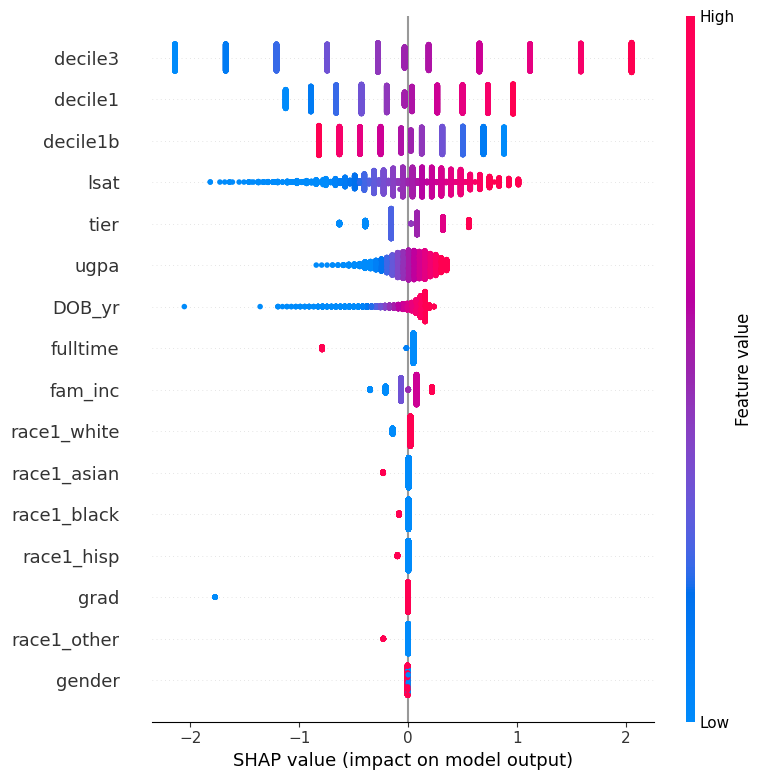

In [210]:

# Load the data
X_train = pd.read_csv('data/X_train_non_scaled.csv', index_col=0)
X_test = pd.read_csv('data/X_test_non_scaled.csv', index_col=0)
y_train = pd.read_csv('data/y_train.csv', index_col=0)
y_test = pd.read_csv('data/y_test.csv', index_col=0)

# Ensure y_train and y_test are Series
y_train = y_train.iloc[:, 0]
y_test = y_test.iloc[:, 0]

# Standardize numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert scaled data back to DataFrame with the original index
X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

# Train a logistic regression model
model = LogisticRegression(max_iter=200, class_weight='balanced', solver='liblinear')
model.fit(X_train_scaled, y_train)

# Evaluate on the test set
y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Create a SHAP explainer object
explainer = shap.Explainer(model, X_train_scaled, model_output="probability")

# Compute SHAP values
shap_values = explainer.shap_values(X_test_scaled)

# Plot SHAP summary plot
shap.summary_plot(shap_values, X_test_scaled, feature_names=X_train.columns)


In [211]:
fair_PCA_train = pd.read_csv('data/X_train_fair_PCA.csv', index_col=0)
fair_PCA_test = pd.read_csv('data/X_test_fair_PCA.csv', index_col=0)


In [212]:

# Ensure gender filtering uses the original non-scaled data
indexes_with_gender_1 = X_test[X_test['gender'] == 1].index

# Filter the scaled test data using the indices
X_test_filtered = X_test_scaled.loc[indexes_with_gender_1]

# Predict probabilities for the filtered data
probabilities = model.predict_proba(X_test_filtered)

# Calculate the absolute difference between the probabilities of the two classes
prob_diff = np.abs(probabilities[:, 0] - probabilities[:, 1])

# Create a DataFrame to hold the filtered data and the probabilities
filtered_data_with_probs = pd.DataFrame(
    np.column_stack((X_test_filtered.values, probabilities, prob_diff)),
    columns=X_test_filtered.columns.tolist() + ['prob_class_0', 'prob_class_1', 'prob_diff'],
    index=X_test_filtered.index  # Preserve original indices
)

# Sort the data by the absolute difference between the class probabilities
sorted_filtered_data = filtered_data_with_probs.sort_values(by='prob_diff')

# Output the top 10 data points where the probabilities are most balanced
top_10_balanced = sorted_filtered_data.head(10)

# Display the probabilities for the top 10 balanced data points
for index, row in top_10_balanced.iterrows():
    print(f"Index: {index}, Probabilities: Class 0 = {row['prob_class_0']:.4f}, Class 1 = {row['prob_class_1']:.4f}")

# Load fair PCA data for further analysis
fair_PCA_test = pd.read_csv('data/X_test_fair_PCA.csv', index_col=0)

# Optionally check if indices in `top_10_balanced` are present in `fair_PCA_test`
missing_indices = [idx for idx in top_10_balanced.index if idx not in fair_PCA_test.index]
if missing_indices:
    print("Missing indices in fair_PCA_test:", missing_indices)
else:
    print("All indices are present in fair_PCA_test.")


Index: 6073, Probabilities: Class 0 = 0.5002, Class 1 = 0.4998
Index: 5777, Probabilities: Class 0 = 0.5005, Class 1 = 0.4995
Index: 2692, Probabilities: Class 0 = 0.5005, Class 1 = 0.4995
Index: 10432, Probabilities: Class 0 = 0.5006, Class 1 = 0.4994
Index: 1948, Probabilities: Class 0 = 0.5010, Class 1 = 0.4990
Index: 20360, Probabilities: Class 0 = 0.4988, Class 1 = 0.5012
Index: 12027, Probabilities: Class 0 = 0.4988, Class 1 = 0.5012
Index: 11959, Probabilities: Class 0 = 0.4975, Class 1 = 0.5025
Index: 18971, Probabilities: Class 0 = 0.5025, Class 1 = 0.4975
Index: 1301, Probabilities: Class 0 = 0.4973, Class 1 = 0.5027
All indices are present in fair_PCA_test.


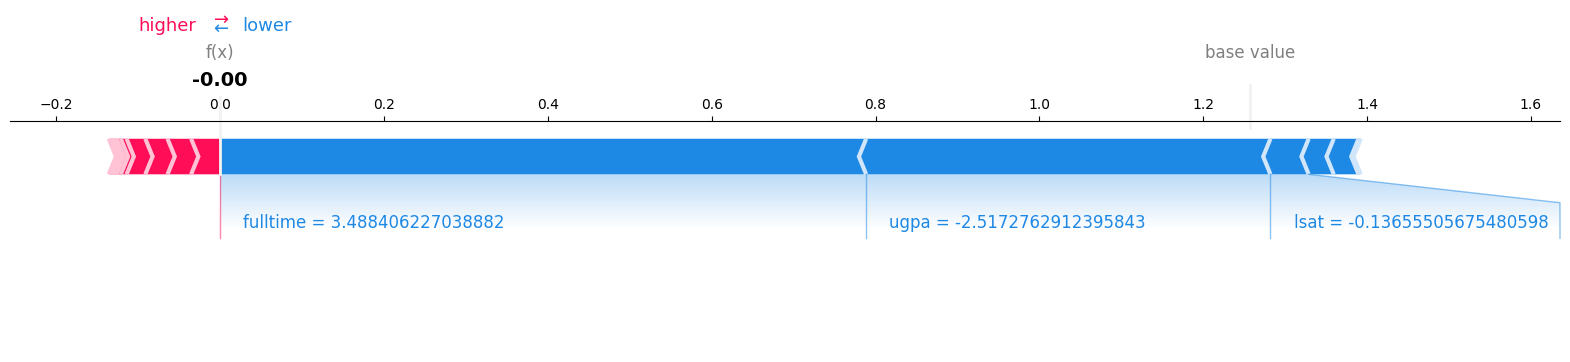

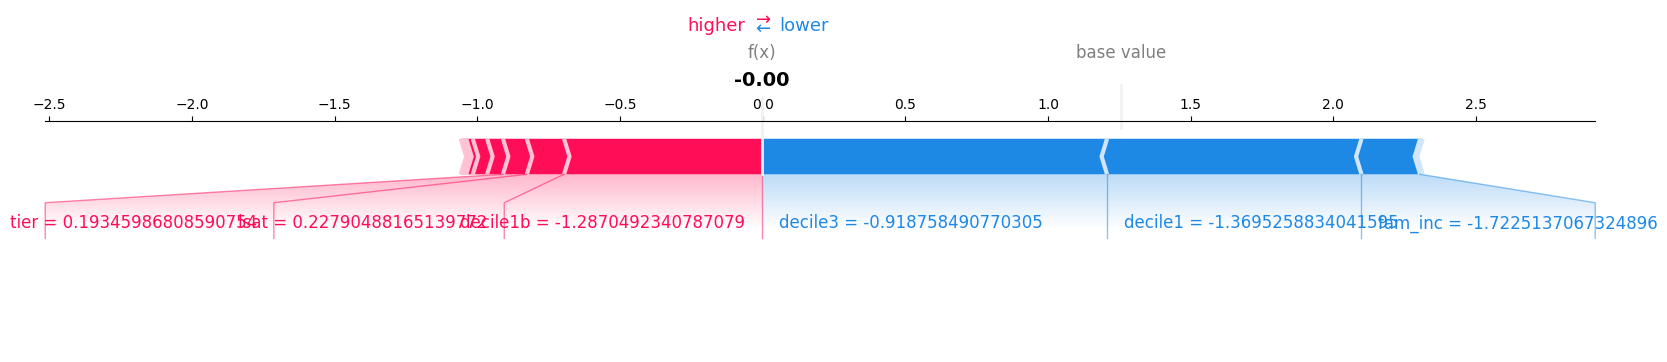

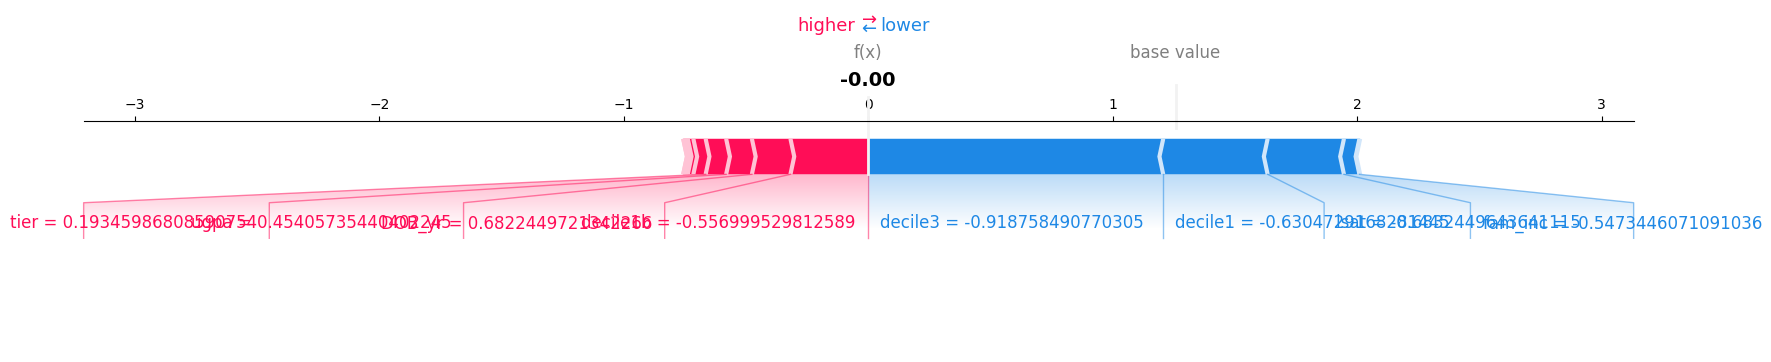

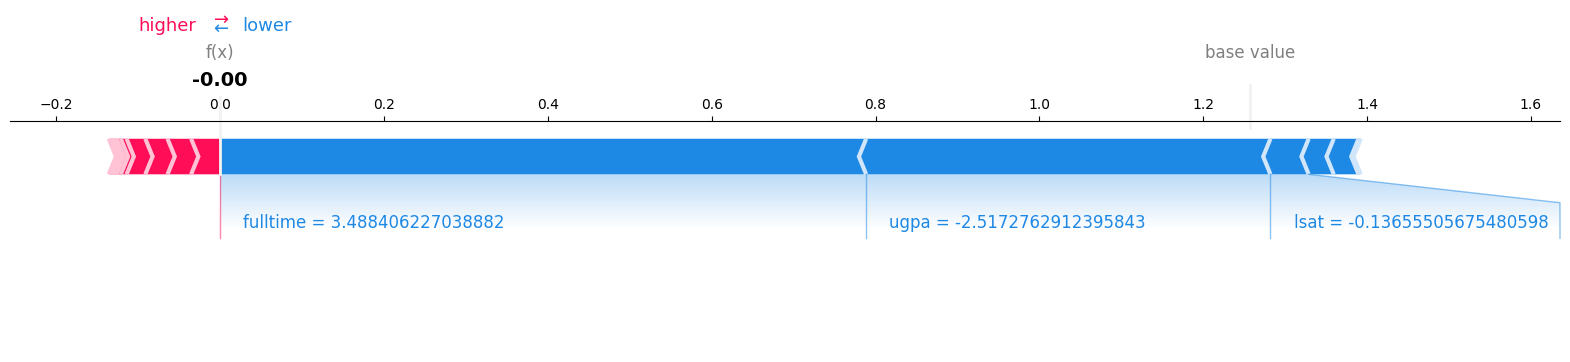

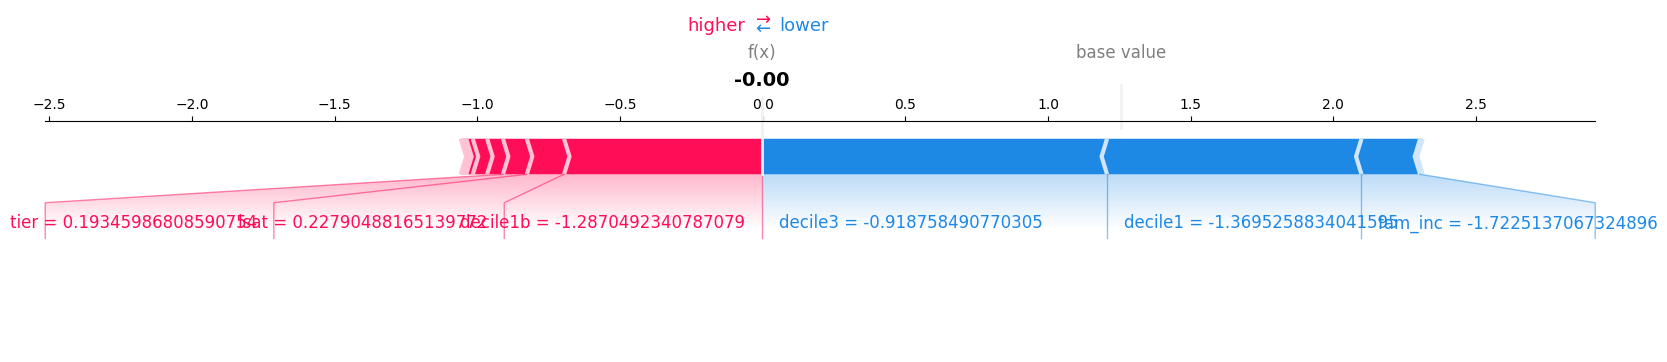

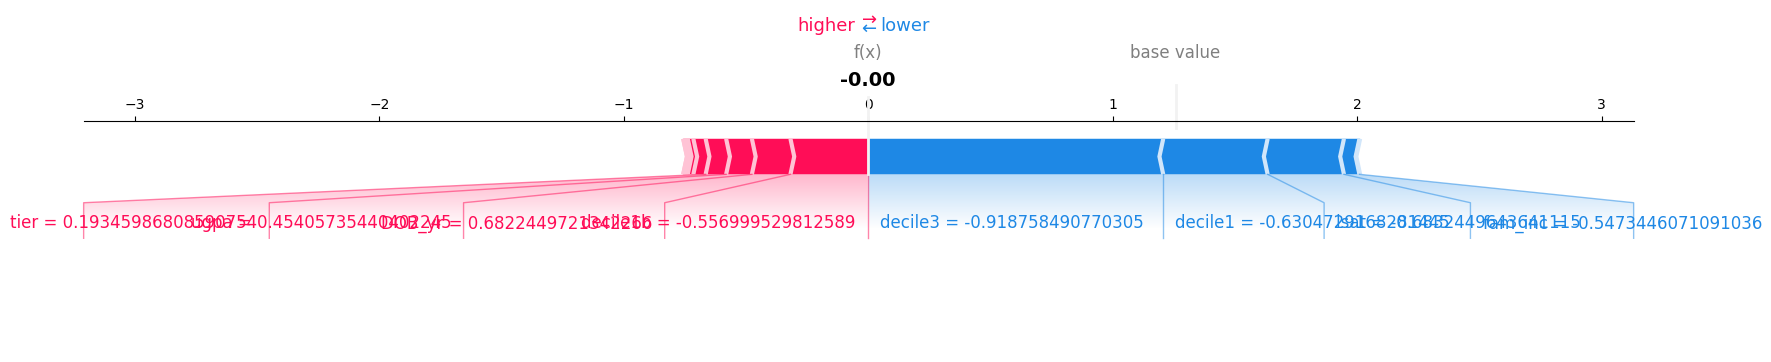

In [218]:

# Create SHAP explainer for the scaled test data used for training the model
explainer = shap.Explainer(model, X_train_scaled)

# Calculate SHAP values for the filtered test data
shap_values = explainer(X_test_filtered)

# Plot SHAP force plots for each of the top 10 observations
for index in top_10_balanced.index[:3]:  # Adjust the range if you want more or fewer plots
    row_idx = X_test_filtered.index.get_loc(index)  # Get the row index in the filtered DataFrame
    
    # Generate the SHAP force plot for the current index
    force_plot = shap.force_plot(explainer.expected_value, shap_values[row_idx].values, X_test_filtered.iloc[row_idx],
                                 matplotlib=True, show=False)
    
    # Adjust the plot to hide the values
    for annotation in force_plot.findobj(match=plt.Annotation):
        annotation.set_visible(False)
    


    plt.show()


In [ ]:
# Get the indices of the top 10 balanced data points
indices_of_interest = top_10_balanced.index

# Filter the Fair PCA test data
fair_PCA_filtered = fair_PCA_test.loc[indices_of_interest]


In [ ]:



# Train a logistic regression model
model = LogisticRegression(max_iter=200, class_weight='balanced', solver='liblinear')
model.fit(fair_PCA_train, y_train)

# Evaluate on the test set
y_pred = model.predict(fair_PCA_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")


Accuracy: 0.6503792949576082


In [ ]:


# Predict probabilities on the filtered Fair PCA test data
probabilities_fair_pca = model.predict_proba(fair_PCA_filtered)

# Calculate the absolute difference between the probabilities of the two classes
prob_diff_fair_pca = np.abs(probabilities_fair_pca[:, 0] - probabilities_fair_pca[:, 1])

# Create a DataFrame to hold the filtered data and the probabilities
filtered_fair_pca_with_probs = pd.DataFrame(
    np.column_stack((fair_PCA_filtered, probabilities_fair_pca, prob_diff_fair_pca)),
    columns=fair_PCA_filtered.columns.tolist() + ['prob_class_0', 'prob_class_1', 'prob_diff'],
    index=indices_of_interest  # Use the original indices for easy reference
)

# Assuming you have the gold labels for fair PCA test data in a DataFrame `gold_labels`
# Load gold labels for filtered Fair PCA test data
gold_labels = pd.read_csv('data/y_test.csv', index_col=0)

# Merge the gold labels with the filtered Fair PCA DataFrame
filtered_fair_pca_with_probs = filtered_fair_pca_with_probs.join(gold_labels)

# Sort the data by the absolute difference between the class probabilities
sorted_fair_pca = filtered_fair_pca_with_probs.sort_values(by='prob_diff')

# Extract the top 10 data points where the probabilities are most balanced
top_10_balanced_fair_pca = sorted_fair_pca.head(10)

# Display the probabilities and gold labels for the top 10 balanced data points
for index, row in top_10_balanced_fair_pca.iterrows():
    print(f"Index: {index}, Gold Label: {row['pass_bar']}, "
          f"Probabilities: Class 0 = {row['prob_class_0']:.4f}, "
          f"Class 1 = {row['prob_class_1']:.4f}, "
          f"Difference = {row['prob_diff']:.4f}")


Index: 6073, Gold Label: 1.0, Probabilities: Class 0 = 0.4915, Class 1 = 0.5085, Difference = 0.0171
Index: 10432, Gold Label: 1.0, Probabilities: Class 0 = 0.5177, Class 1 = 0.4823, Difference = 0.0353
Index: 5777, Gold Label: 1.0, Probabilities: Class 0 = 0.4807, Class 1 = 0.5193, Difference = 0.0387
Index: 1301, Gold Label: 1.0, Probabilities: Class 0 = 0.4748, Class 1 = 0.5252, Difference = 0.0504
Index: 2692, Gold Label: 1.0, Probabilities: Class 0 = 0.4383, Class 1 = 0.5617, Difference = 0.1234
Index: 20360, Gold Label: 1.0, Probabilities: Class 0 = 0.4320, Class 1 = 0.5680, Difference = 0.1360
Index: 18971, Gold Label: 1.0, Probabilities: Class 0 = 0.3255, Class 1 = 0.6745, Difference = 0.3489
Index: 1948, Gold Label: 1.0, Probabilities: Class 0 = 0.6832, Class 1 = 0.3168, Difference = 0.3665
Index: 11959, Gold Label: 1.0, Probabilities: Class 0 = 0.1963, Class 1 = 0.8037, Difference = 0.6075
Index: 12027, Gold Label: 1.0, Probabilities: Class 0 = 0.8237, Class 1 = 0.1763, Diffe